In [1]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler

In [2]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf

In [3]:
from matplotlib import pyplot
from PIL import Image
from PIL import ImageFilter
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import numpy as np
import pandas as pd




In [4]:
# Hyperparameters
batch_size = 64
num_classes = 10
epochs = 150
l = 16
num_filter = 24

compression = 0.5
dropout_rate = 0

In [5]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

170500096/170498071 [==============================] - 6s 0us/step


In [6]:
y_train.shape

(50000, 10)

In [7]:
X_train.shape


(50000, 32, 32, 3)

In [8]:
X_test.shape

(10000, 32, 32, 3)

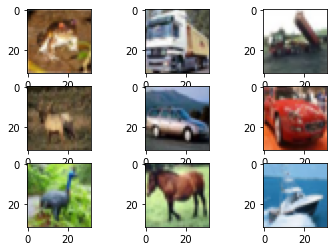

In [9]:
#observing first 10 pictures
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(X_train[i])
# show the figure
pyplot.show()

In [10]:
#Sharpening the train and Test images
from scipy import misc
from scipy import ndimage
aug=iaa.Sharpen(alpha=0.4,lightness=0.8)
X_train_new=[]
for i in range(len(y_train)): 
  sharpened=aug.augment_image(X_train[i])
  X_train_new.append(sharpened)


In [11]:
X_test_new=[]
for i in range(len(y_test)): 
  sharpened=aug.augment_image(X_test[i])
  X_test_new.append(sharpened)


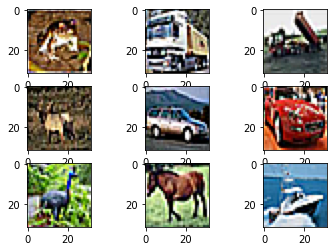

In [12]:
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(X_train_new[i])
# show the figure
pyplot.show()

In [13]:
#Normalizing the pixels
def prep_pixels(train,test):
  train_1 = np.array(train,dtype=np.float32)
  test_1 = np.array(test,dtype=np.float32)
  train_norm=train_1/255.0
  test_norm=test_1/255.0
  return train_norm, test_norm

In [14]:
X_train_norm,X_test_norm=prep_pixels(X_train_new,X_test_new)

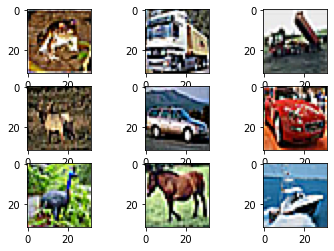

In [15]:
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(X_train_norm[i])
# show the figure
pyplot.show()

In [16]:
#Certain Augmentations
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator( rotation_range=20,
                 width_shift_range=0.125, height_shift_range=0.125,
                 horizontal_flip=True,fill_mode='nearest',zoom_range=0.1)
datagen.fit(X_train_norm)
train_data=datagen.flow(X_train_norm,y_train,batch_size=64)
print(len(train_data))

782


In [17]:
img_height, img_width, channel = X_train_norm.shape[1],X_train_norm.shape[2],X_train_norm.shape[3]


In [18]:
# Dense Block
def denseblock(input, num_filter = 24, dropout_rate = 0,l=16):
    global compression
    temp = input
    for _ in range(l):
      BatchNorm = layers.BatchNormalization(beta_regularizer=l2(1E-4),gamma_regularizer=l2(1E-4))(temp)
      relu = layers.Activation('relu')(BatchNorm)
      Conv2D_1_1 = layers.Conv2D(4*int(num_filter*compression), (1,1), use_bias=False ,padding='same',kernel_initializer="he_uniform",kernel_regularizer=l2(1E-4))(relu)
      
      BatchNorm1 = layers.BatchNormalization(beta_regularizer=l2(1E-4),gamma_regularizer=l2(1E-4))(Conv2D_1_1)
      relu1 = layers.Activation('relu')(BatchNorm1)
      
      Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same',kernel_initializer="he_uniform",kernel_regularizer=l2(1E-4))(relu1)
      
        
      concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
      temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0):
    global compression
    n_channels=input.shape.as_list()[-1]
    BatchNorm = layers.BatchNormalization(beta_regularizer=l2(1E-4),gamma_regularizer=l2(1E-4))(input)
    relu = layers.Activation('relu')(BatchNorm)
    
    Conv2D_BottleNeck = layers.Conv2D(int(n_channels*compression), (1,1), use_bias=False ,padding='same',kernel_initializer="he_uniform",kernel_regularizer=l2(1E-4))(relu)
    
    avg = layers.AveragePooling2D(pool_size=(2,2),padding='same')(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization(beta_regularizer=l2(1E-4),gamma_regularizer=l2(1E-4))(input)
    

    AvgPooling = layers.GlobalAveragePooling2D()(BatchNorm)
    
    output = layers.Dense(num_classes, activation='softmax',kernel_regularizer=l2(1E-4),bias_regularizer=l2(1E-4))(AvgPooling)
    return output

In [19]:
from tensorflow.keras.regularizers import l2
dropout_rate = 0
num_filter=24

input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(24,3,padding="same",use_bias=False,bias_initializer='zeros',kernel_regularizer=l2(1E-4))(input)
#First_pool=layers.MaxPool2D((2,2),strides=(2,2))(First_Conv2D)

First_Block = denseblock(First_Conv2D,num_filter, dropout_rate,16)
First_Transition = transition(First_Block,  dropout_rate)

Second_Block = denseblock(First_Transition,num_filter, dropout_rate,16)
Second_Transition = transition(Second_Block,  dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate,16)



output = output_layer(Third_Block)

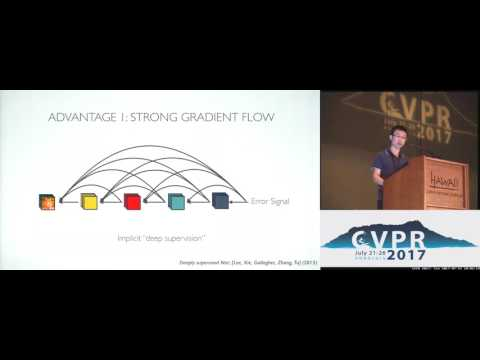

In [20]:
#https://arxiv.org/pdf/1608.06993.pdf
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo(id='-W6y8xnd--U', width=600)

In [21]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 24)   648         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 24)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 24)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [22]:
# determine Loss function and Optimizer
#Compiling the model

opt_sgd=tf.keras.optimizers.SGD(lr = 0.1,momentum = 0.9,nesterov = True)
model.compile(loss='categorical_crossentropy',
              optimizer = opt_sgd,
              metrics=['accuracy'])

In [23]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [24]:
(X_train_norm).shape[0]

50000

In [25]:
#Setting the learning rate , CSVLogger and Model Checkpoint
from tensorflow.keras.callbacks import CSVLogger,ModelCheckpoint,ReduceLROnPlateau



csv_logger = CSVLogger('/content/drive/My Drive/training_final.log')
lr_reducer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=0.0001)

filepath = "/content/drive/My Drive/Model_final.hdf5"
model_chkpt = ModelCheckpoint(filepath, monitor = "val_accuracy", save_best_only=True, verbose = 1)

In [26]:
print(len(X_train_norm))

50000


In [27]:
#Fitting the model
history = model.fit_generator(
    train_data,
    steps_per_epoch=len(train_data),
    epochs=150,
    verbose = 1,
    validation_data=(X_test_norm, y_test),
    callbacks = [lr_reducer,model_chkpt,csv_logger]
)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/150
782/782 [==============================] - ETA: 0s - loss: 2.9808 - accuracy: 0.5077
Epoch 00001: val_accuracy improved from -inf to 0.34760, saving model to /content/drive/My Drive/Model_final.hdf5
782/782 [==============================] - 156s 199ms/step - loss: 2.9808 - accuracy: 0.5077 - val_loss: 4.2414 - val_accuracy: 0.3476
Epoch 2/150
782/782 [==============================] - ETA: 0s - loss: 2.2175 - accuracy: 0.6516
Epoch 00002: val_accuracy improved from 0.34760 to 0.49110, saving model to /content/drive/My Drive/Model_final.hdf5
782/782 [==============================] - 154s 196ms/step - loss: 2.2175 - accuracy: 0.6516 - val_loss: 2.5716 - val_accuracy: 0.4911
Epoch 3/150
782/782 [==============================] - ETA: 0s - loss: 1.7853 - accuracy: 0.7137
Epoch 00003: val_accuracy improved from 0.49110 to 0.63220, saving model to /content/drive/My Drive/Model_final.hdf5
782/782 [======

KeyboardInterrupt: ignored

In [31]:
#Loading the history from CSVLogger
log_data = pd.read_csv('/content/drive/My Drive/training_final.log', sep=',', engine='python')

In [32]:
log_data

,epoch,accuracy,loss,lr,val_accuracy,val_loss
0,0,0.50770,2.980767,0.100000,0.3476,4.241422
1,1,0.65162,2.217546,0.100000,0.4911,2.571571
2,2,0.71370,1.785337,0.100000,0.6322,1.975171
3,3,0.75190,1.500811,0.100000,0.7271,1.511196
4,4,0.77168,1.303920,0.100000,0.6628,1.573259
5,5,0.78788,1.161070,0.100000,0.6708,1.620410
6,6,0.79624,1.064827,0.100000,0.6210,1.842649
7,7,0.83622,0.903834,0.050000,0.8414,0.877455
8,8,0.84622,0.841255,0.050000,0.7400,1.228497
9,9,0.84920,0.807456,0.050000,0.8269,0.870450


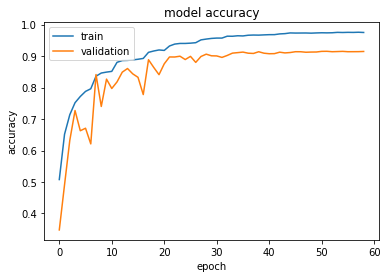

In [37]:
#Plotting Train and Validation Accuracy
import matplotlib.pyplot as plt

plt.plot(log_data['epoch'],log_data['accuracy'])
plt.plot(log_data['epoch'],log_data['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


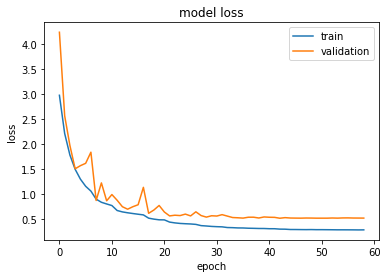

In [39]:
#Plotting train and validation loss
import matplotlib.pyplot as plt

plt.plot(log_data['epoch'],log_data['loss'])
plt.plot(log_data['epoch'],log_data['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


In [36]:
#Evaluation the test loss and accuracy
score = model.evaluate(X_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])


Test score: 0.5251480340957642
Test accuracy: 0.914900004863739
